### 1. Import and data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

In [2]:
df = pd.read_csv("../data/chess_games_feature.csv")
df.head()

,WhiteElo,BlackElo,ResultNumeric,EventTypeID,RatingDiff,AvgRating,WhiteIsHigherRated,WhiteRatingAdvantage,ECOID,w_material_early,...,w_castled_early,b_castled_early,w_checks_early,b_checks_early,early_checks,w_piece_activity,b_piece_activity,both_castled_early,total_captures_early,activity_diff
0,2504,2371,2,0,133,2437.5,1,133,0,34.0,...,1.0,1.0,0.0,0.0,0.0,41.0,39.0,1,6.0,2.0
1,2487,2596,1,0,109,2541.5,0,-109,0,20.0,...,1.0,1.0,1.0,1.0,2.0,33.0,31.0,1,13.0,2.0
2,2915,2921,1,0,6,2918.0,0,-6,0,32.0,...,1.0,1.0,0.0,0.0,0.0,31.0,37.0,1,6.0,-6.0
3,2542,2433,2,0,109,2487.5,1,109,10,26.0,...,1.0,0.0,1.0,0.0,1.0,34.0,28.0,0,7.0,6.0
4,2473,2658,0,0,185,2565.5,0,-185,0,28.0,...,1.0,1.0,3.0,0.0,3.0,30.0,35.0,1,9.0,-5.0


### 2. Prepare data

In [3]:
X = df.drop('ResultNumeric', axis=1)
y = df['ResultNumeric']

print(f"Features: {X.shape}")
print(f"Target: {y.shape}")

Features: (3031382, 33)
Target: (3031382,)


### 3. Train test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,        # 20% for testing
    random_state=42,
    stratify=y
)

#### Scale feature

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4. Train model

In [6]:
lr_model = LogisticRegression(
    max_iter=2000,
    solver='saga',
    random_state=42,
    n_jobs=-1,
)

In [7]:
start_time = time.time()

lr_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

Training completed in 31.31 seconds (0.52 minutes)


### 5. Evaluate

In [8]:
y_pred = lr_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

print("Classification Report: \n")
print(classification_report(y_test, y_pred, target_names=['Black Win', 'Draw', 'White Win']))

Accuracy: 0.5917 (59.17%)

Classification Report: 

              precision    recall  f1-score   support

   Black Win       0.57      0.59      0.58    249346
        Draw       0.74      0.29      0.42     81759
   White Win       0.59      0.68      0.63    275172

    accuracy                           0.59    606277
   macro avg       0.64      0.52      0.54    606277
weighted avg       0.60      0.59      0.58    606277



### 6. Confusion Matrix

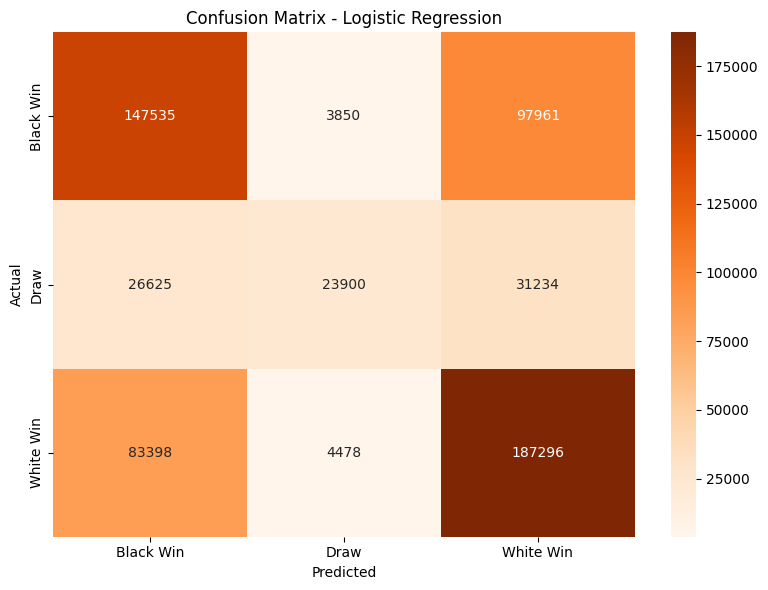

In [9]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Black Win', 'Draw', 'White Win'],
            yticklabels=['Black Win', 'Draw', 'White Win'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Logistic Regression')
plt.tight_layout()
plt.show()

### 7. Coefficients (Feature importance for linear models)

                  Feature  Coefficient
6    WhiteRatingAdvantage     0.183002
1                BlackElo     0.137035
0                WhiteElo     0.133989
4               AvgRating     0.127106
2             EventTypeID     0.101846
8        w_material_early     0.078411
9        b_material_early     0.075116
3              RatingDiff     0.065774
10    material_diff_early     0.062004
32          activity_diff     0.042302
28       w_piece_activity     0.031607
30     both_castled_early     0.030447
29       b_piece_activity     0.022343
24        b_castled_early     0.021697
23        w_castled_early     0.021163
13     capture_diff_early     0.020768
7                   ECOID     0.015356
16  aggression_diff_early     0.014992
5      WhiteIsHigherRated     0.012537
27           early_checks     0.011160
25         w_checks_early     0.011080
17       w_center_control     0.010835
15     b_aggression_early     0.008536
21          b_development     0.008246
14     w_aggression_early

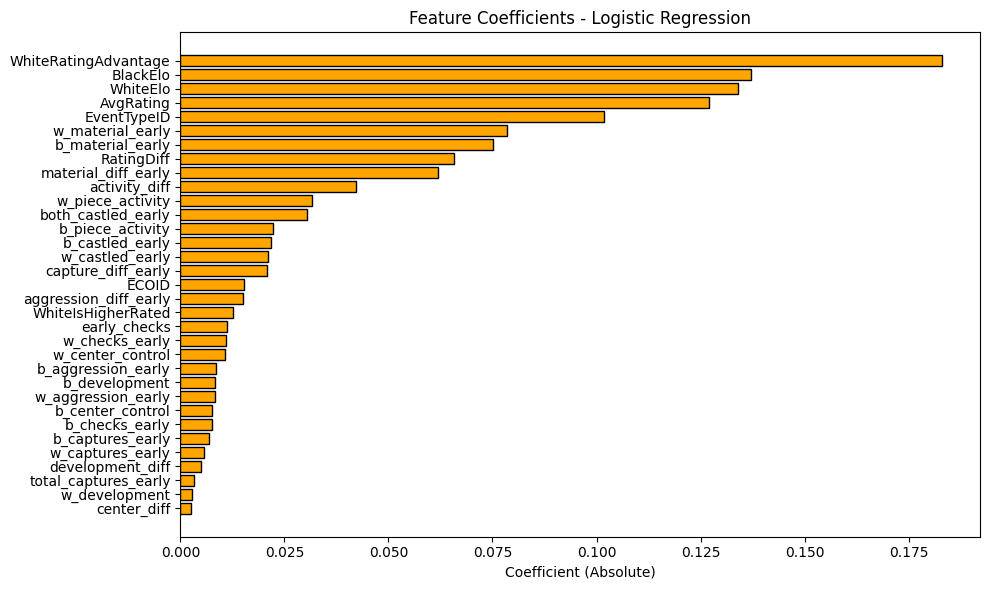

In [10]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': np.abs(lr_model.coef_).mean(axis=0)  # Average across classes
}).sort_values('Coefficient', ascending=False)

print(coef_df)

plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], 
         color='orange', edgecolor='black')
plt.xlabel('Coefficient (Absolute)')
plt.title('Feature Coefficients - Logistic Regression')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()